<a href="https://colab.research.google.com/github/bhagatshivam/Ask-the-Doc/blob/main/cognitive_robotics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio --quiet
!pip install opencv-python scikit-learn matplotlib --quiet


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import cv2
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

import random

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA available: True
Using device: cuda


In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Transforms for CNN (normalisation etc.)
transform_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean of CIFAR-10
                         (0.2023, 0.1994, 0.2010))  # std of CIFAR-10
])

# Download CIFAR-10
train_dataset_full = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_cnn
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_cnn
)

print("Total training images:", len(train_dataset_full))
print("Total test images:", len(test_dataset))
print("Classes:", train_dataset_full.classes)


100%|██████████| 170M/170M [00:08<00:00, 19.4MB/s]


Total training images: 50000
Total test images: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
# Create train / val split from training set
val_size = 5000
train_size = len(train_dataset_full) - val_size

train_dataset, val_dataset = random_split(
    train_dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))

# Dataloaders for CNN (we'll tune batch_size later, for now 128)
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)



Train size: 45000
Val size: 5000


Batch shape: torch.Size([128, 3, 32, 32])


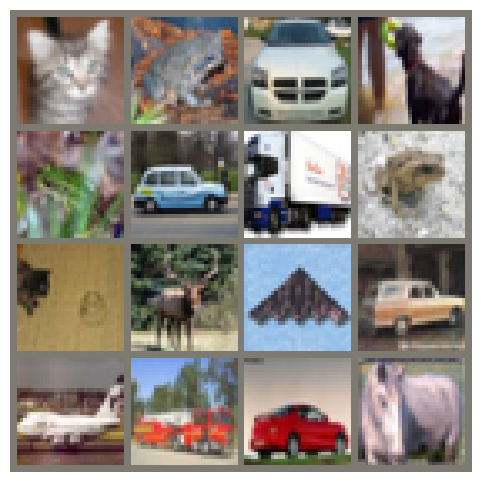

Labels: ['cat', 'frog', 'automobile', 'dog', 'frog', 'automobile', 'truck', 'frog', 'cat', 'deer', 'airplane', 'automobile', 'airplane', 'truck', 'automobile', 'horse']


In [5]:
# Helper to show a batch of images (unnormalised for plotting)
classes = train_dataset_full.classes

def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Batch shape:", images.shape)
imshow(torchvision.utils.make_grid(images[:16], nrow=4))
print("Labels:", [classes[l] for l in labels[:16]])


In [6]:
class SmallCIFAR10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Block 1: 3x32x32 -> 32x16x16
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 32x16x16
        )
        # Block 2: 32x16x16 -> 64x8x8
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 64x8x8
        )
        # Optional Block 3: 64x8x8 -> 128x4x4
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 128x4x4
        )

        # Fully-connected head
        self.fc = nn.Sequential(
            nn.Flatten(),                    # 128 * 4 * 4 = 2048
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc(x)
        return x

# Quick sanity check of model dimensions
model = SmallCIFAR10CNN(num_classes=10).to(device)
print(model)


SmallCIFAR10CNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bia

In [7]:
from tqdm.auto import tqdm

def train_model(model, train_loader, val_loader, device,
                num_epochs=15, lr=1e-3, weight_decay=1e-4):
    """Train the model and return history + best model state."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    best_val_acc = 0.0
    best_state_dict = None

    for epoch in range(1, num_epochs + 1):
        # ---- Training ----
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - train", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} - val", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total

        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_acc"].append(epoch_train_acc)
        history["val_acc"].append(epoch_val_acc)

        print(f"Epoch [{epoch}/{num_epochs}] - "
              f"train_loss: {epoch_train_loss:.4f}, train_acc: {epoch_train_acc:.4f} "
              f"- val_loss: {epoch_val_loss:.4f}, val_acc: {epoch_val_acc:.4f}")

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_state_dict = model.state_dict()

    print(f"\nBest validation accuracy: {best_val_acc:.4f}")
    return history, best_state_dict


def evaluate_model(model, data_loader, device):
    """Compute accuracy and confusion matrix on a dataset."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm


def plot_history(history):
    """Plot train/val loss and accuracy curves."""
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/10] - train_loss: 1.6334, train_acc: 0.3955 - val_loss: 1.3426, val_acc: 0.5178


Epoch 2/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2/10] - train_loss: 1.1968, train_acc: 0.5697 - val_loss: 0.9985, val_acc: 0.6504


Epoch 3/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3/10] - train_loss: 0.9744, train_acc: 0.6582 - val_loss: 0.9049, val_acc: 0.6798


Epoch 4/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4/10] - train_loss: 0.8376, train_acc: 0.7088 - val_loss: 0.8210, val_acc: 0.7188


Epoch 5/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5/10] - train_loss: 0.7414, train_acc: 0.7419 - val_loss: 0.7009, val_acc: 0.7470


Epoch 6/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6/10] - train_loss: 0.6629, train_acc: 0.7722 - val_loss: 0.6762, val_acc: 0.7594


Epoch 7/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 7/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7/10] - train_loss: 0.5958, train_acc: 0.7901 - val_loss: 0.6470, val_acc: 0.7740


Epoch 8/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 8/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8/10] - train_loss: 0.5409, train_acc: 0.8109 - val_loss: 0.6604, val_acc: 0.7716


Epoch 9/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 9/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9/10] - train_loss: 0.4794, train_acc: 0.8325 - val_loss: 0.6420, val_acc: 0.7832


Epoch 10/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/10] - train_loss: 0.4359, train_acc: 0.8468 - val_loss: 0.6542, val_acc: 0.7758

Best validation accuracy: 0.7832


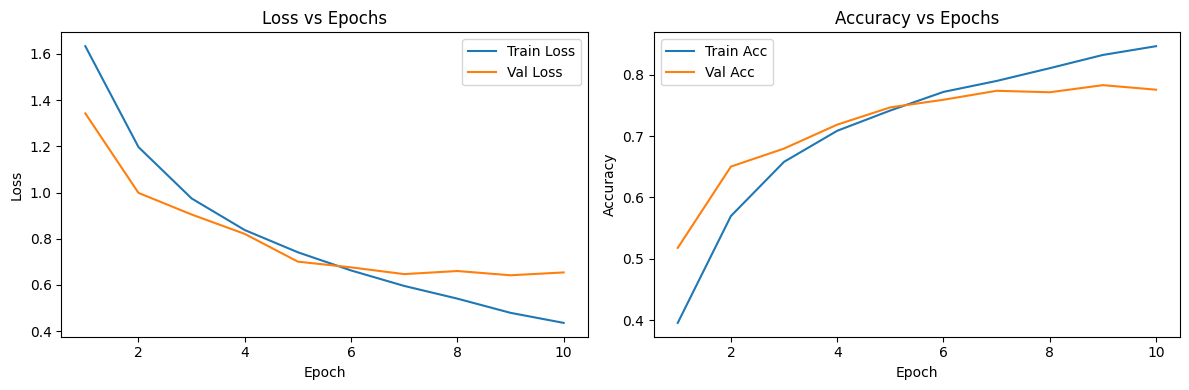

In [11]:
# Recreate a fresh model for training
baseline_model = SmallCIFAR10CNN(num_classes=10).to(device)

num_epochs = 10          # <- reduce from 15 to 10 for now
learning_rate = 1e-3
weight_decay = 1e-4

history_baseline, best_state_baseline = train_model(
    baseline_model,
    train_loader,
    val_loader,
    device,
    num_epochs=num_epochs,
    lr=learning_rate,
    weight_decay=weight_decay
)

plot_history(history_baseline)


Test accuracy (baseline CNN): 0.7731


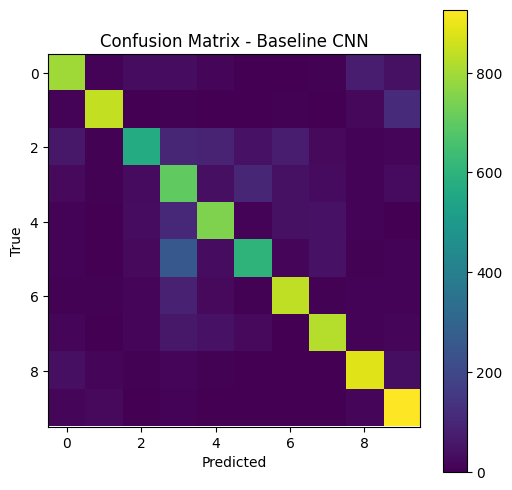

In [12]:
baseline_model.load_state_dict(best_state_baseline)

test_acc, test_cm = evaluate_model(baseline_model, test_loader, device)
print("Test accuracy (baseline CNN):", test_acc)

plt.figure(figsize=(6, 6))
plt.imshow(test_cm, interpolation='nearest')
plt.title("Confusion Matrix - Baseline CNN")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [13]:
results_cnn = {}

# Store baseline results (A) – edit these if your numbers differ slightly
results_cnn["A_baseline_3blocks_lr1e-3"] = {
    "val_best": max(history_baseline["val_acc"]),
    "test_acc": float(test_acc)  # from earlier evaluation cell
}

results_cnn


{'A_baseline_3blocks_lr1e-3': {'val_best': 0.7832, 'test_acc': 0.7731}}

Epoch 1/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/10] - train_loss: 1.7852, train_acc: 0.3499 - val_loss: 1.4826, val_acc: 0.4660


Epoch 2/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2/10] - train_loss: 1.4454, train_acc: 0.4779 - val_loss: 1.2968, val_acc: 0.5334


Epoch 3/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3/10] - train_loss: 1.2765, train_acc: 0.5444 - val_loss: 1.1555, val_acc: 0.5884


Epoch 4/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4/10] - train_loss: 1.1396, train_acc: 0.5980 - val_loss: 1.0443, val_acc: 0.6306


Epoch 5/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5/10] - train_loss: 1.0368, train_acc: 0.6382 - val_loss: 0.9559, val_acc: 0.6560


Epoch 6/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6/10] - train_loss: 0.9557, train_acc: 0.6666 - val_loss: 0.8777, val_acc: 0.6884


Epoch 7/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 7/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7/10] - train_loss: 0.8910, train_acc: 0.6874 - val_loss: 0.8590, val_acc: 0.6946


Epoch 8/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 8/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8/10] - train_loss: 0.8273, train_acc: 0.7122 - val_loss: 0.8723, val_acc: 0.6942


Epoch 9/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 9/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9/10] - train_loss: 0.7760, train_acc: 0.7287 - val_loss: 0.7866, val_acc: 0.7244


Epoch 10/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/10] - train_loss: 0.7252, train_acc: 0.7467 - val_loss: 0.7618, val_acc: 0.7304

Best validation accuracy: 0.7304


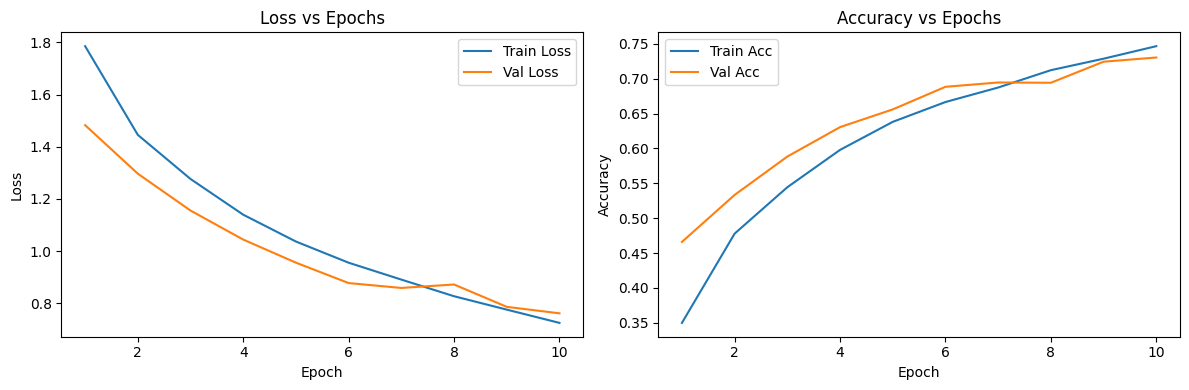

Test accuracy (Model B - 3 blocks, lr=3e-4): 0.7241


{'A_baseline_3blocks_lr1e-3': {'val_best': 0.7832, 'test_acc': 0.7731},
 'B_3blocks_lr3e-4': {'val_best': 0.7304, 'test_acc': 0.7241}}

In [14]:
# Model B: 3 conv blocks, lower learning rate (3e-4)
model_b = SmallCIFAR10CNN(num_classes=10).to(device)

num_epochs_b = 10
learning_rate_b = 3e-4
weight_decay_b = 1e-4

history_b, best_state_b = train_model(
    model_b,
    train_loader,
    val_loader,
    device,
    num_epochs=num_epochs_b,
    lr=learning_rate_b,
    weight_decay=weight_decay_b
)

plot_history(history_b)

# Load best weights and evaluate on test set
model_b.load_state_dict(best_state_b)
test_acc_b, test_cm_b = evaluate_model(model_b, test_loader, device)
print("Test accuracy (Model B - 3 blocks, lr=3e-4):", test_acc_b)

# Save result into dictionary (optional)
results_cnn["B_3blocks_lr3e-4"] = {
    "val_best": max(history_b["val_acc"]),
    "test_acc": float(test_acc_b)
}
results_cnn


In [15]:
class SmallCIFAR10CNN_2Block(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Block 1: 3x32x32 -> 32x16x16
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 32x16x16
        )
        # Block 2: 32x16x16 -> 64x8x8
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 64x8x8
        )

        # Fully-connected head: 64 * 8 * 8 = 4096
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.fc(x)
        return x

# Quick sanity check
model_c_test = SmallCIFAR10CNN_2Block(num_classes=10).to(device)
print(model_c_test)


SmallCIFAR10CNN_2Block(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


Epoch 1/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/10] - train_loss: 1.5644, train_acc: 0.4285 - val_loss: 1.2084, val_acc: 0.5662


Epoch 2/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2/10] - train_loss: 1.1459, train_acc: 0.5910 - val_loss: 1.0025, val_acc: 0.6500


Epoch 3/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3/10] - train_loss: 0.9624, train_acc: 0.6600 - val_loss: 0.8726, val_acc: 0.6908


Epoch 4/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4/10] - train_loss: 0.8371, train_acc: 0.7066 - val_loss: 0.8026, val_acc: 0.7096


Epoch 5/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5/10] - train_loss: 0.7520, train_acc: 0.7359 - val_loss: 0.7159, val_acc: 0.7426


Epoch 6/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6/10] - train_loss: 0.6798, train_acc: 0.7602 - val_loss: 0.6948, val_acc: 0.7586


Epoch 7/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 7/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7/10] - train_loss: 0.6136, train_acc: 0.7814 - val_loss: 0.6774, val_acc: 0.7636


Epoch 8/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 8/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8/10] - train_loss: 0.5606, train_acc: 0.8016 - val_loss: 0.6732, val_acc: 0.7682


Epoch 9/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 9/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9/10] - train_loss: 0.5079, train_acc: 0.8190 - val_loss: 0.6793, val_acc: 0.7624


Epoch 10/10 - train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10/10 - val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/10] - train_loss: 0.4658, train_acc: 0.8374 - val_loss: 0.6635, val_acc: 0.7800

Best validation accuracy: 0.7800


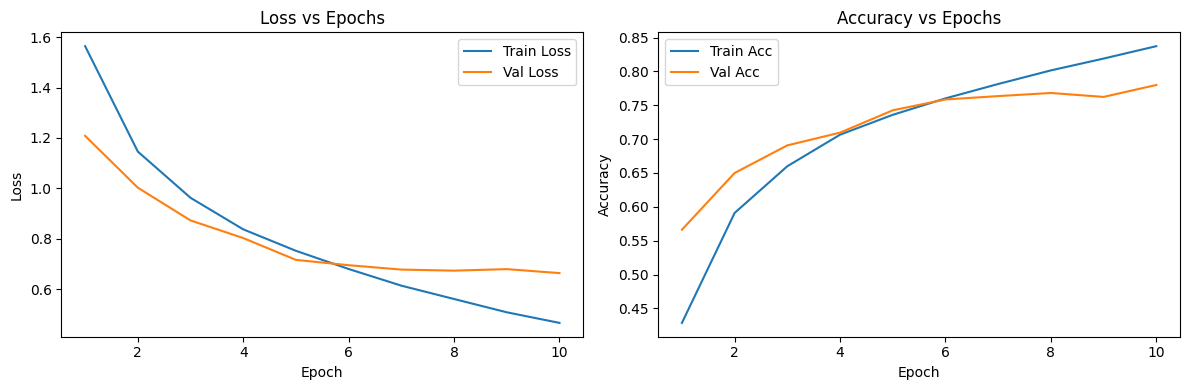

Test accuracy (Model C - 2 blocks, lr=1e-3): 0.7736


{'A_baseline_3blocks_lr1e-3': {'val_best': 0.7832, 'test_acc': 0.7731},
 'B_3blocks_lr3e-4': {'val_best': 0.7304, 'test_acc': 0.7241},
 'C_2blocks_lr1e-3': {'val_best': 0.78, 'test_acc': 0.7736}}

In [16]:
# Model C: 2 conv blocks, same LR as baseline
model_c = SmallCIFAR10CNN_2Block(num_classes=10).to(device)

num_epochs_c = 10
learning_rate_c = 1e-3
weight_decay_c = 1e-4

history_c, best_state_c = train_model(
    model_c,
    train_loader,
    val_loader,
    device,
    num_epochs=num_epochs_c,
    lr=learning_rate_c,
    weight_decay=weight_decay_c
)

plot_history(history_c)

# Evaluate on test set
model_c.load_state_dict(best_state_c)
test_acc_c, test_cm_c = evaluate_model(model_c, test_loader, device)
print("Test accuracy (Model C - 2 blocks, lr=1e-3):", test_acc_c)

results_cnn["C_2blocks_lr1e-3"] = {
    "val_best": max(history_c["val_acc"]),
    "test_acc": float(test_acc_c)
}
results_cnn


In [17]:
from torchvision.datasets import CIFAR10

# Raw CIFAR-10 datasets (PIL images, no transform)
cifar10_train_full_raw = CIFAR10(root="./data", train=True, download=False, transform=None)
cifar10_test_raw = CIFAR10(root="./data", train=False, download=False, transform=None)

print("Raw train size:", len(cifar10_train_full_raw))
print("Raw test size:", len(cifar10_test_raw))

# Get the same indices used for CNN train/val split
train_indices = train_dataset.indices
val_indices = val_dataset.indices

len(train_indices), len(val_indices)


Raw train size: 50000
Raw test size: 10000


(45000, 5000)

In [18]:
def pil_to_gray_np(img, size=64):
    """
    Convert a PIL RGB image to a resized grayscale numpy array for OpenCV.
    """
    img = img.resize((size, size))              # resize to 64x64
    img_np = np.array(img)                      # RGB
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    return gray

# ORB feature extractor (local keypoints + binary descriptors)
orb = cv2.ORB_create(nfeatures=200)

# Quick test on one image
sample_img, sample_label = cifar10_train_full_raw[0]
gray = pil_to_gray_np(sample_img)
kp, des = orb.detectAndCompute(gray, None)
print("Gray shape:", gray.shape)
print("Keypoints:", len(kp))
print("Descriptor shape:", des.shape if des is not None else None)


Gray shape: (64, 64)
Keypoints: 0
Descriptor shape: None


In [19]:
def extract_descriptors_from_indices(dataset, indices, max_images=None):
    """
    Extract ORB descriptors from a subset of images given by indices.
    Returns a big ndarray of shape (N_descriptors, 32).
    """
    all_desc = []
    count = 0

    for idx in tqdm(indices, desc="Extracting ORB descriptors"):
        img, label = dataset[idx]
        gray = pil_to_gray_np(img)
        kp, des = orb.detectAndCompute(gray, None)
        if des is not None:
            all_desc.append(des)

        count += 1
        if (max_images is not None) and (count >= max_images):
            break

    if len(all_desc) == 0:
        return None

    all_desc = np.vstack(all_desc)
    return all_desc

# Let's use descriptors from first ~10,000 training images for vocabulary
desc_sample = extract_descriptors_from_indices(
    cifar10_train_full_raw,
    train_indices,
    max_images=10000
)

print("Collected descriptors:", desc_sample.shape)


Extracting ORB descriptors:   0%|          | 0/45000 [00:00<?, ?it/s]

Collected descriptors: (693, 32)


In [20]:
# Subsample descriptors for k-means
max_descriptors = 100_000
if desc_sample.shape[0] > max_descriptors:
    rand_idxs = np.random.choice(desc_sample.shape[0], max_descriptors, replace=False)
    vocab_descriptors = desc_sample[rand_idxs]
else:
    vocab_descriptors = desc_sample

vocab_descriptors = vocab_descriptors.astype(np.float32)
vocab_descriptors.shape


(693, 32)

In [21]:
def build_vocabulary(descriptors, k=200):
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        batch_size=1000,
        verbose=1,
        random_state=42
    )
    kmeans.fit(descriptors)
    return kmeans

K_200 = 200
kmeans_200 = build_vocabulary(vocab_descriptors, k=K_200)
print("BoW vocabulary (K=200) built.")


Init 1/1 with method k-means++
Inertia for init 1/1: 67395992.0
[MiniBatchKMeans] Reassigning 27 cluster centers.
Minibatch step 1/100: mean batch inertia: 99993.67388167388
Minibatch step 2/100: mean batch inertia: 74650.13564213565, ewa inertia: 74650.13564213565
Minibatch step 3/100: mean batch inertia: 71805.56421356421, ewa inertia: 71805.56421356421
Minibatch step 4/100: mean batch inertia: 69050.48196248196, ewa inertia: 69050.48196248196
Minibatch step 5/100: mean batch inertia: 69236.5541125541, ewa inertia: 69236.5541125541
Minibatch step 6/100: mean batch inertia: 66757.443001443, ewa inertia: 66757.443001443
Minibatch step 7/100: mean batch inertia: 69252.83694083695, ewa inertia: 69252.83694083695
Minibatch step 8/100: mean batch inertia: 64744.57142857143, ewa inertia: 64744.57142857143
Minibatch step 9/100: mean batch inertia: 65864.08658008659, ewa inertia: 65864.08658008659
Minibatch step 10/100: mean batch inertia: 67598.2683982684, ewa inertia: 67598.2683982684
Minib

In [22]:
def compute_bow_features(dataset, indices, kmeans, size=64):
    K = kmeans.n_clusters
    X = np.zeros((len(indices), K), dtype=np.float32)
    y = np.zeros(len(indices), dtype=np.int64)

    for i, idx in enumerate(tqdm(indices, desc="Building BoW features")):
        img, label = dataset[idx]
        gray = pil_to_gray_np(img, size=size)
        kp, des = orb.detectAndCompute(gray, None)

        if des is not None:
            des = des.astype(np.float32)
            words = kmeans.predict(des)
            hist, _ = np.histogram(words, bins=np.arange(K + 1))
            hist = hist.astype(np.float32)
            hist /= (hist.sum() + 1e-7)
            X[i] = hist
        else:
            # no keypoints found -> leave histogram as zeros
            X[i] = np.zeros(K, dtype=np.float32)

        y[i] = label

    return X, y

# Build BoW features for train, val, and test (K=200)
X_train_bow_200, y_train_bow = compute_bow_features(
    cifar10_train_full_raw, train_indices, kmeans_200
)
X_val_bow_200, y_val_bow = compute_bow_features(
    cifar10_train_full_raw, val_indices, kmeans_200
)
X_test_bow_200, y_test_bow = compute_bow_features(
    cifar10_test_raw, range(len(cifar10_test_raw)), kmeans_200
)

X_train_bow_200.shape, X_val_bow_200.shape, X_test_bow_200.shape


Building BoW features:   0%|          | 0/45000 [00:00<?, ?it/s]

Building BoW features:   0%|          | 0/5000 [00:00<?, ?it/s]

Building BoW features:   0%|          | 0/10000 [00:00<?, ?it/s]

((45000, 200), (5000, 200), (10000, 200))

Training SVM (K=200)...
BoW + SVM (K=200) - train_acc: 0.1106, val_acc: 0.0970, test_acc: 0.1015


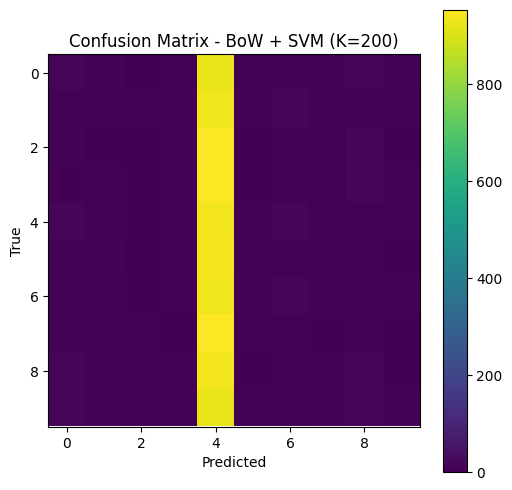

In [23]:
# Linear SVM classifier
svm_200 = SVC(kernel="linear", C=1.0, random_state=42)

print("Training SVM (K=200)...")
svm_200.fit(X_train_bow_200, y_train_bow)

train_acc_200 = svm_200.score(X_train_bow_200, y_train_bow)
val_acc_200 = svm_200.score(X_val_bow_200, y_val_bow)
test_acc_200 = svm_200.score(X_test_bow_200, y_test_bow)

print(f"BoW + SVM (K=200) - train_acc: {train_acc_200:.4f}, "
      f"val_acc: {val_acc_200:.4f}, test_acc: {test_acc_200:.4f}")

# Confusion matrix on test set
y_test_pred_200 = svm_200.predict(X_test_bow_200)
cm_bow_200 = confusion_matrix(y_test_bow, y_test_pred_200)

plt.figure(figsize=(6, 6))
plt.imshow(cm_bow_200, interpolation='nearest')
plt.title("Confusion Matrix - BoW + SVM (K=200)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [24]:
# Reduce dataset size for BoW (for speed)
np.random.seed(42)

train_indices_bow = np.random.choice(train_indices, size=10000, replace=False)
val_indices_bow = np.random.choice(val_indices, size=2000, replace=False)
test_indices_bow = np.random.choice(range(len(cifar10_test_raw)), size=5000, replace=False)

len(train_indices_bow), len(val_indices_bow), len(test_indices_bow)


(10000, 2000, 5000)

In [25]:
X_train_bow_200, y_train_bow = compute_bow_features(
    cifar10_train_full_raw, train_indices_bow, kmeans_200
)

X_val_bow_200, y_val_bow = compute_bow_features(
    cifar10_train_full_raw, val_indices_bow, kmeans_200
)

X_test_bow_200, y_test_bow = compute_bow_features(
    cifar10_test_raw, test_indices_bow, kmeans_200
)


Building BoW features:   0%|          | 0/10000 [00:00<?, ?it/s]

Building BoW features:   0%|          | 0/2000 [00:00<?, ?it/s]

Building BoW features:   0%|          | 0/5000 [00:00<?, ?it/s]

In [26]:
svm_200 = SVC(kernel="linear", C=1.0)

svm_200.fit(X_train_bow_200, y_train_bow)

train_acc_200 = svm_200.score(X_train_bow_200, y_train_bow)
val_acc_200 = svm_200.score(X_val_bow_200, y_val_bow)
test_acc_200 = svm_200.score(X_test_bow_200, y_test_bow)

print(f"BoW + SVM (K=200) - "
      f"train: {train_acc_200:.4f}, "
      f"val: {val_acc_200:.4f}, "
      f"test: {test_acc_200:.4f}")


BoW + SVM (K=200) - train: 0.1207, val: 0.0930, test: 0.1022


In [27]:
# Build another vocabulary with K=100
K_100 = 100
kmeans_100 = build_vocabulary(vocab_descriptors, k=K_100)
print("BoW vocabulary (K=100) built.")

# Compute BoW features on subset indices
X_train_bow_100, y_train_bow_100 = compute_bow_features(
    cifar10_train_full_raw, train_indices_bow, kmeans_100
)
X_val_bow_100, y_val_bow_100 = compute_bow_features(
    cifar10_train_full_raw, val_indices_bow, kmeans_100
)
X_test_bow_100, y_test_bow_100 = compute_bow_features(
    cifar10_test_raw, test_indices_bow, kmeans_100
)

# Train linear SVM for K=100
svm_100 = SVC(kernel="linear", C=1.0)
svm_100.fit(X_train_bow_100, y_train_bow_100)

train_acc_100 = svm_100.score(X_train_bow_100, y_train_bow_100)
val_acc_100 = svm_100.score(X_val_bow_100, y_val_bow_100)
test_acc_100 = svm_100.score(X_test_bow_100, y_test_bow_100)

print(f"BoW + SVM (K=100) - train: {train_acc_100:.4f}, "
      f"val: {val_acc_100:.4f}, test: {test_acc_100:.4f}")


Init 1/1 with method k-means++
Inertia for init 1/1: 82095136.0
[MiniBatchKMeans] Reassigning 2 cluster centers.
Minibatch step 1/100: mean batch inertia: 120758.09523809524
Minibatch step 2/100: mean batch inertia: 94104.79653679654, ewa inertia: 94104.79653679654
Minibatch step 3/100: mean batch inertia: 87917.42568542568, ewa inertia: 87917.42568542568
Minibatch step 4/100: mean batch inertia: 85656.19624819625, ewa inertia: 85656.19624819625
Minibatch step 5/100: mean batch inertia: 85449.32756132756, ewa inertia: 85449.32756132756
Minibatch step 6/100: mean batch inertia: 86164.00577200577, ewa inertia: 86164.00577200577
Minibatch step 7/100: mean batch inertia: 87445.7950937951, ewa inertia: 87445.7950937951
Minibatch step 8/100: mean batch inertia: 82952.64646464646, ewa inertia: 82952.64646464646
Minibatch step 9/100: mean batch inertia: 84514.58585858585, ewa inertia: 84514.58585858585
Minibatch step 10/100: mean batch inertia: 84635.87301587302, ewa inertia: 84635.87301587302

Building BoW features:   0%|          | 0/10000 [00:00<?, ?it/s]

Building BoW features:   0%|          | 0/2000 [00:00<?, ?it/s]

Building BoW features:   0%|          | 0/5000 [00:00<?, ?it/s]

BoW + SVM (K=100) - train: 0.1188, val: 0.0945, test: 0.1004


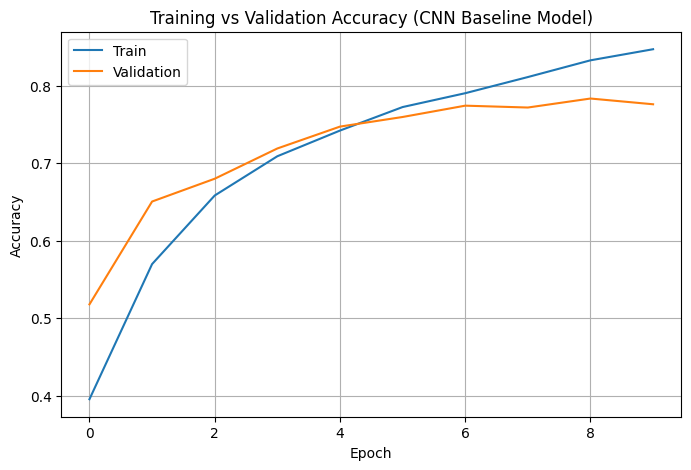

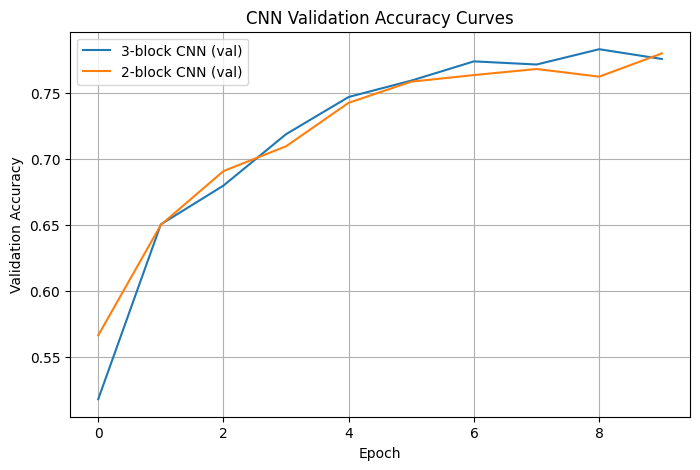

In [28]:
def plot_accuracy_curves(histories, labels):
    plt.figure(figsize=(8,5))
    for history, label in zip(histories, labels):
        plt.plot(history["val_acc"], label=f"{label} (val)")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title("CNN Validation Accuracy Curves")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_train_val_accuracy(history, title):
    plt.figure(figsize=(8,5))
    plt.plot(history["train_acc"], label="Train")
    plt.plot(history["val_acc"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot for baseline model (Model A)
plot_train_val_accuracy(
    history_baseline,
    title="Training vs Validation Accuracy (CNN Baseline Model)"
)

# Optional comparison: baseline vs shallow model
plot_accuracy_curves(
    histories=[history_baseline, history_c],
    labels=["3-block CNN", "2-block CNN"]
)


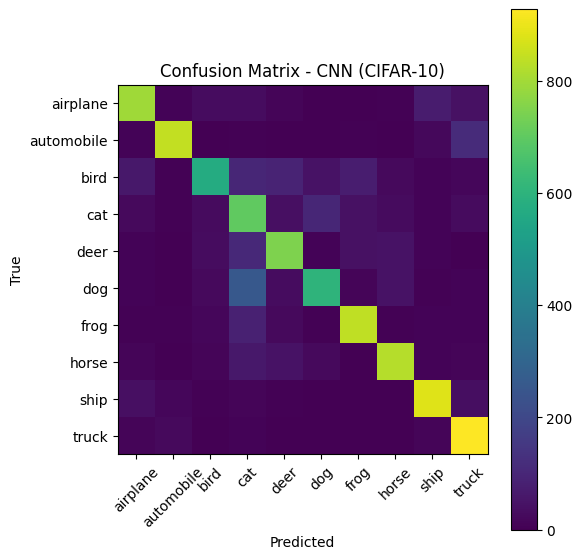

In [29]:
# CNN confusion matrix (using best-performing CNN)
labels = train_dataset_full.classes

plt.figure(figsize=(6,6))
plt.imshow(test_cm, interpolation='nearest')  # use test_cm from CNN
plt.title("Confusion Matrix - CNN (CIFAR-10)")
plt.colorbar()
plt.xticks(range(10), labels, rotation=45)
plt.yticks(range(10), labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


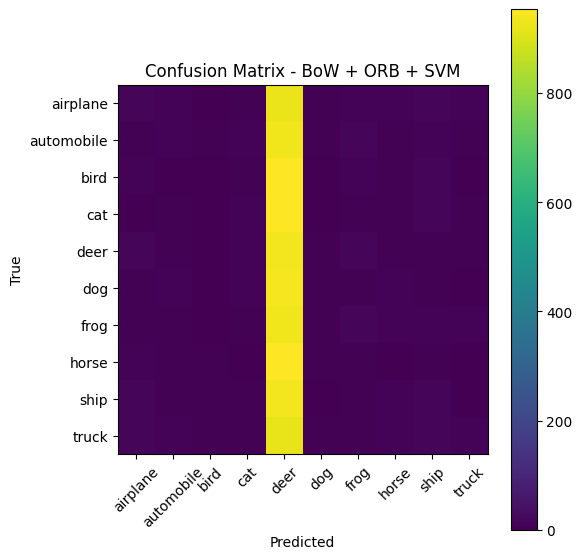

In [35]:
#BoW confusion matrix (K = 200)
plt.figure(figsize=(6,6))
plt.imshow(cm_bow_200, interpolation='nearest')
plt.title("Confusion Matrix - BoW + ORB + SVM")
plt.colorbar()
plt.xticks(range(10), labels, rotation=45)
plt.yticks(range(10), labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
